<a href="https://colab.research.google.com/github/Z3376/Joint-Intent-Classification-and-Slot-Filling/blob/master/Copy_of_intent_classifier3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip /content/gdrive/My\ Drive/Language_2.zip

Archive:  /content/gdrive/My Drive/Language_2.zip
   creating: Language_2/
  inflating: Language_2/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/Language_2/
  inflating: __MACOSX/Language_2/._.DS_Store  
  inflating: Language_2/intents.csv  
  inflating: Language_2/Round1_Problem2-of-2_Problem.pdf  
  inflating: __MACOSX/Language_2/._Round1_Problem2-of-2_Problem.pdf  
  inflating: Language_2/slots.csv    
  inflating: Language_2/test.csv     
  inflating: Language_2/train.csv    
  inflating: Language_2/train_intent.csv  
  inflating: Language_2/train_slots.csv  
  inflating: Language_2/vocab.csv    


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import GRU
from keras.layers import LSTM
from keras.models import Sequential
from keras import backend as K
from keras.layers import Dense
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [0]:
train = pd.read_csv('./Language_2/train.csv')
train = train.iloc[:].values
test = pd.read_csv('./Language_2/test.csv')
test = test.iloc[:].values
train_intent = pd.read_csv('./Language_2/train_intent.csv')
train_intent = train_intent.iloc[:].values
intent = pd.read_csv('./Language_2/intents.csv')
intent = intent.iloc[:].values
vocab = pd.read_csv('./Language_2/vocab.csv')
vocab = vocab.iloc[:].values
train_slots = pd.read_csv('./Language_2/train_slots.csv')
train_slots = train_slots.iloc[:].values
slots = pd.read_csv('./Language_2/slots.csv')
slots = slots.iloc[:].values

In [0]:
l = 4000
ltest = len(train)-l

In [0]:
train_data = np.zeros((l,48),dtype='int32')
for i in range(l):
  a = train[i][0].split()
  train_data[i] = np.array([int(a[j])-1 if j<len(a) else 0 for j in range(48)])
train_data = to_categorical(train_data,num_classes=942)

In [0]:
train_out_data = np.zeros((l,48),dtype='int32')
for i in range(l):
  a = train_slots[i][0].split()
  train_out_data[i] = np.array([int(a[j])-1 if j<len(a) else 0 for j in range(48)])
train_out_data = to_categorical(train_out_data,num_classes=128)

In [0]:
train_intent_data = np.array([int(train_intent[i][0]) for i in range(l)])
train_intent_data = to_categorical(train_intent_data)

In [0]:
test_data = np.zeros((ltest,48),dtype='int32')
for i in range(l,len(train)):
  a = train[i-l][0].split()
  test_data[i-l] = np.array([int(a[j])-1 if j<len(a) else 0 for j in range(48)])
test_data = to_categorical(test_data,num_classes=942)

In [0]:
test_out_data = np.zeros((ltest,48),dtype='int32')
for i in range(l,len(train)):
  a = train_slots[i-l][0].split()
  test_out_data[i-l] = np.array([int(a[j])-1 if j<len(a) else 0 for j in range(48)])
test_out_data = to_categorical(test_out_data,num_classes=128)

In [0]:
test_intent_data = np.array([int(train_intent[i-l][0]) for i in range(l,len(train))])
test_intent_data = to_categorical(test_intent_data)

# RNNs

In [0]:
gru_units = 200

In [0]:
inpt = Input((None,942))
gru = GRU(gru_units,return_sequences=True)
gru_outpt = gru(inpt)
outpt = TimeDistributed(Dense(128,activation='softmax'))(gru_outpt)
slot_model = Model(inpt,outpt)
slot_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 942)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 200)         685800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 128)         25728     
Total params: 711,528
Trainable params: 711,528
Non-trainable params: 0
_________________________________________________________________


In [0]:
encoder_inpt = Input((None,942))
encoderGRU = GRU(gru_units,return_sequences=True,return_state=True)
_,h_state = encoderGRU(encoder_inpt)
encoder = Model(encoder_inpt,h_state)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 942)         0         
_________________________________________________________________
gru_2 (GRU)                  [(None, None, 200), (None 685800    
Total params: 685,800
Trainable params: 685,800
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder_inpt = Input((None,942))
decoderGRU = GRU(gru_units)
decoderGRU_outpt = decoderGRU(decoder_inpt,initial_state=h_state)
intent_outpt = Dense(26,activation='softmax')(decoderGRU_outpt)
intent_model = Model([decoder_inpt,encoder_inpt],intent_outpt)
intent_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 942)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 942)    0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     [(None, None, 200),  685800      input_2[0][0]                    
__________________________________________________________________________________________________
gru_3 (GRU)                     (None, 200)          685800      input_3[0][0]                    
                                                                 gru_2[0][1]                      
__________

In [0]:
plot_model(intent_model, to_file='intent_model.png')
plot_model(slot_model, to_file='slot_model.png')

# Train

In [0]:
def seq_loss_fn(s):
  def seq(y_true,y_pred):
    y_mul = np.zeros((s,1))
    for i in range(s):
      y_mul[i] = i
    y_mul = K.cast(y_mul,K.floatx())
    y_true = K.dot(y_true,y_mul)
    y_pred = K.dot(y_pred,y_mul)
    return K.mean(K.square(y_true-y_pred))
  return seq
seq_loss128 = seq_loss_fn(128)
seq_loss26 = seq_loss_fn(26)

In [0]:
def seq_metric_fn(s):
  def seq_metric(y_true,y_pred):
    y_mul = np.zeros((s,1))
    for i in range(s):
      y_mul[i] = i
    y_mul = K.cast(y_mul,K.floatx())
    y_true = K.dot(y_true,y_mul)
    y_pred = K.dot(y_pred,y_mul)
    return K.mean(K.square(y_true-y_pred))
  return seq_metric
seq_metric128 = seq_metric_fn(128)
seq_metric26 = seq_metric_fn(26)

In [0]:
print(np.argmax(train_data,axis=-1)[:5])
print(np.argmax(train_out_data,axis=-1)[:5])
print(np.argmax(train_intent_data,axis=-1)[:5])

In [0]:
slot_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc',seq_metric128])
intent_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc',seq_metric26])

In [0]:
es = EarlyStopping(monitor='val_seq_metric', mode='min', verbose=1,patience=2)
cp = ModelCheckpoint(filepath='./gdrive/My Drive/Colab Notebooks/slot_weights.hdf5',monitor='val_seq_metric',mode='min', verbose=1,save_weights_only=True, save_best_only=True)

In [0]:
history1 = slot_model.fit(train_data,train_out_data,epochs=10,batch_size=1,validation_split=0.05,callbacks=[es,cp])

Instructions for updating:
Use tf.cast instead.
Train on 3800 samples, validate on 200 samples
Epoch 1/10
3800/3800 [==============================] - 176s 46ms/step - loss: 0.1529 - acc: 0.9721 - seq_metric: 111.6955 - val_loss: 0.0371 - val_acc: 0.9914 - val_seq_metric: 15.3108

Epoch 00001: val_seq_metric improved from inf to 15.31083, saving model to ./gdrive/My Drive/Colab Notebooks/slot_weights.hdf5
Epoch 2/10
3800/3800 [==============================] - 176s 46ms/step - loss: 0.0249 - acc: 0.9941 - seq_metric: 11.6444 - val_loss: 0.0203 - val_acc: 0.9945 - val_seq_metric: 7.6016

Epoch 00002: val_seq_metric improved from 15.31083 to 7.60159, saving model to ./gdrive/My Drive/Colab Notebooks/slot_weights.hdf5
Epoch 3/10
3800/3800 [==============================] - 175s 46ms/step - loss: 0.0138 - acc: 0.9966 - seq_metric: 6.7250 - val_loss: 0.0186 - val_acc: 0.9957 - val_seq_metric: 7.7767

Epoch 00003: val_seq_metric did not improve from 7.60159
Epoch 4/10
3800/3800 [============

In [0]:
slot_model.save_weights('slot_model2.h5')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
cp = ModelCheckpoint(filepath='./gdrive/My Drive/Colab Notebooks/intent_weights.hdf5',monitor='val_loss',mode='min', verbose=1,save_weights_only=True, save_best_only=True)

In [0]:
history = intent_model.fit([train_data,train_data],train_intent_data,epochs=10,batch_size=1,validation_split=0.05,callbacks=[es,cp])

Train on 3800 samples, validate on 200 samples
Epoch 1/10
3800/3800 [==============================] - 603s 159ms/step - loss: 0.2471 - acc: 0.9363 - seq_metric: 5.8127 - val_loss: 0.1828 - val_acc: 0.9700 - val_seq_metric: 1.9192

Epoch 00001: val_loss improved from inf to 0.18279, saving model to ./gdrive/My Drive/Colab Notebooks/intent_weights.hdf5
Epoch 2/10
3800/3800 [==============================] - 599s 158ms/step - loss: 0.1345 - acc: 0.9647 - seq_metric: 2.7425 - val_loss: 0.1643 - val_acc: 0.9700 - val_seq_metric: 1.9458

Epoch 00002: val_loss improved from 0.18279 to 0.16427, saving model to ./gdrive/My Drive/Colab Notebooks/intent_weights.hdf5
Epoch 3/10
3800/3800 [==============================] - 599s 158ms/step - loss: 0.0852 - acc: 0.9792 - seq_metric: 1.6708 - val_loss: 0.1353 - val_acc: 0.9750 - val_seq_metric: 1.3927

Epoch 00003: val_loss improved from 0.16427 to 0.13530, saving model to ./gdrive/My Drive/Colab Notebooks/intent_weights.hdf5
Epoch 4/10
3800/3800 [==

In [0]:
intent_model.save_weights('intent_model2.h5')

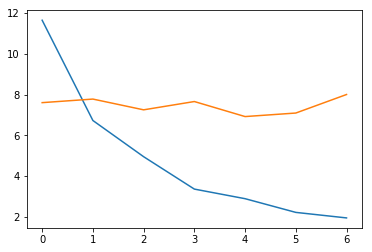

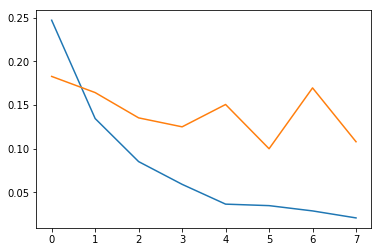

In [0]:
plt.figure()
plt.plot(history1.history['seq_metric'][1:])
plt.plot(history1.history['val_seq_metric'][1:])
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Inference

In [0]:
slots_pred = np.zeros((ltest,48,128),dtype='object')
for i in range(ltest):
  slots_pred[i] = slot_model.predict(test_data[i].reshape(1,48,942))

In [0]:
slots_pred_train = np.zeros((l,48,128),dtype='object')
for i in range(l):
  slots_pred_train[i] = slot_model.predict(train_data[i].reshape(1,48,942))

In [0]:
n=10
print(np.argmax(slots_pred[n],axis=-1))
print(np.argmax(test_out_data[n],axis=-1))

[127 127 127 127 127 127  47 109 127  77 127 127 127  70 127   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[127 127 127 127 127 127  47 109 127  77 127 127 127  70 127   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [0]:
def accuracy(a,b):
  summ = 0
  for n in range(len(a)):
    an = np.argmax(a[n],axis=-1)
    bn = np.argmax(b[n],axis=-1)
    summ += (1 if np.array_equal(an,bn) else 0)
  return float(summ)/len(a)

In [0]:
print('test_accuracy:'+str(accuracy(test_out_data,slots_pred)))
print('train_accuracy:'+str(accuracy(train_out_data,slots_pred_train)))

test_accuracy:0.970317297850563
train_accuracy:0.9675


In [0]:
intent_pred = np.zeros((ltest,26),dtype='object')
for i in range(ltest):
  a = test_data[i].reshape(1,48,942)
  intent_pred[i] = intent_model.predict([a,a])

In [0]:
intent_pred_train = np.zeros((l,26),dtype='object')
for i in range(l):
  a = train_data[i].reshape(1,48,942)
  intent_pred_train[i] = intent_model.predict([a,a])

In [0]:
#print('test_accuracy:'+str(1-np.sum([test_intent_data-np.argmax(intent_pred,axis=-1)])/ltest))
#print('train_accuracy:'+str(1-np.sum([np.argmax(train_intent_data,axis=-1)-np.argmax(intent_pred_train,axis=-1)])/l))

In [0]:
n=350
print(np.argmax(test_intent_data[n],axis=-1))
print(np.argmax(intent_pred[n],axis=-1))

6
6


In [0]:
print('test_accuracy:'+str(accuracy(test_intent_data,intent_pred)))
print('train_accuracy:'+str(accuracy(train_intent_data,intent_pred_train)))

test_accuracy:0.9989764585465711
train_accuracy:0.99725


In [0]:
#K.clear_session()